In [1]:
import ast
import datetime
import torch
import lightning as pl
import pandas as pd
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))
from src.data.data import HuBMapDataModule
from src.model.model import Model

/home/tamukake/Github/HuBMAP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_workers = 10
batch_size = 32
height = 768
width = 768
img_dir = "./data/"
target_name = "blood_vessel"
row_name = "id"
gray_scale = False
pretrained = "imagenet"
backbone = "resnet50"
activation = None
in_channels = 3
epochs = 50
warm_up_epohs = 10
classes = 1
model_mode = "binary"
precision = "16-mixed"  # default 32-true
accumulate_grad_batches = 1
cutmix_args = {
    "prob": 0.50,
    "enable": True,
    "alpha": 0.5,
    "height": height,
    "width": width,
}
df = pd.read_csv("../data/labels_1class.csv")
df['unique_id'] = df['id'] + '_' + df.index.astype(str)
df.set_index('unique_id', inplace=True)

df["coordinates"] = [ast.literal_eval(d) for d in df["coordinates"]]
today = datetime.date.today()
dir_key = today.strftime("%Y%m%d%H%M%S")
model_checkpoint_dir = f"outputs/{dir_key}/{backbone}/"
mode = "min"
train_df, valid_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [3]:
device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model(
        backbone=backbone,
        gray_scale=gray_scale,
        pretrained=pretrained,
        in_channels=in_channels,
        warm_up_epochs=warm_up_epohs,
        epochs=epochs,
        classes=classes,
        mode=model_mode,
        activation=activation,
    )
modelWeight= "../outputs/UNET/resnet50/20230623080628/epoch=42-step=2150.ckpt"
model.load_state_dict(torch.load(modelWeight)['state_dict'])
model.to(device)

Model(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [7]:
import os
import cv2
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rgb_to_grayscale
height = 768
width = 768
mean = [0.62405882, 0.40748174, 0.68217106]
std = [0.15112928, 0.20741797, 0.13163469]
valid_transform = A.Compose([
    A.Resize(height, width, always_apply=True, p=1),
    # A.Normalize(mean=mean, std=std, p=1),
    ToTensorV2(transpose_mask=True),
])
class DatasetTest(Dataset):
    def __init__(self, df,transforms):
        self.df = df 
        self.unique_id = list(df["id"].unique())
        self.transforms = transforms 
    def __getitem__(self, idx):
        target_id = self.unique_id[idx]
        # df[df["id"] == "0006ff2aa7cd"]
        img_path = os.path.join("../data/", "train_images_class1", target_id + ".png")
        im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask_path = os.path.join("../data/", "mask_images_class1", target_id + ".png")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = np.argmax(mask,axis=-1)
        if self.transforms is not None: 
            transformed = self.transforms(image = im)
            return transformed['image']/255,mask/255
    def __len__(self):
        return len(self.unique_id)

In [8]:
from glob import glob
dataset = DatasetTest(valid_df,valid_transform)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

  1%|█                                                                                                                                                                               | 9/1439 [00:00<01:42, 14.00it/s]


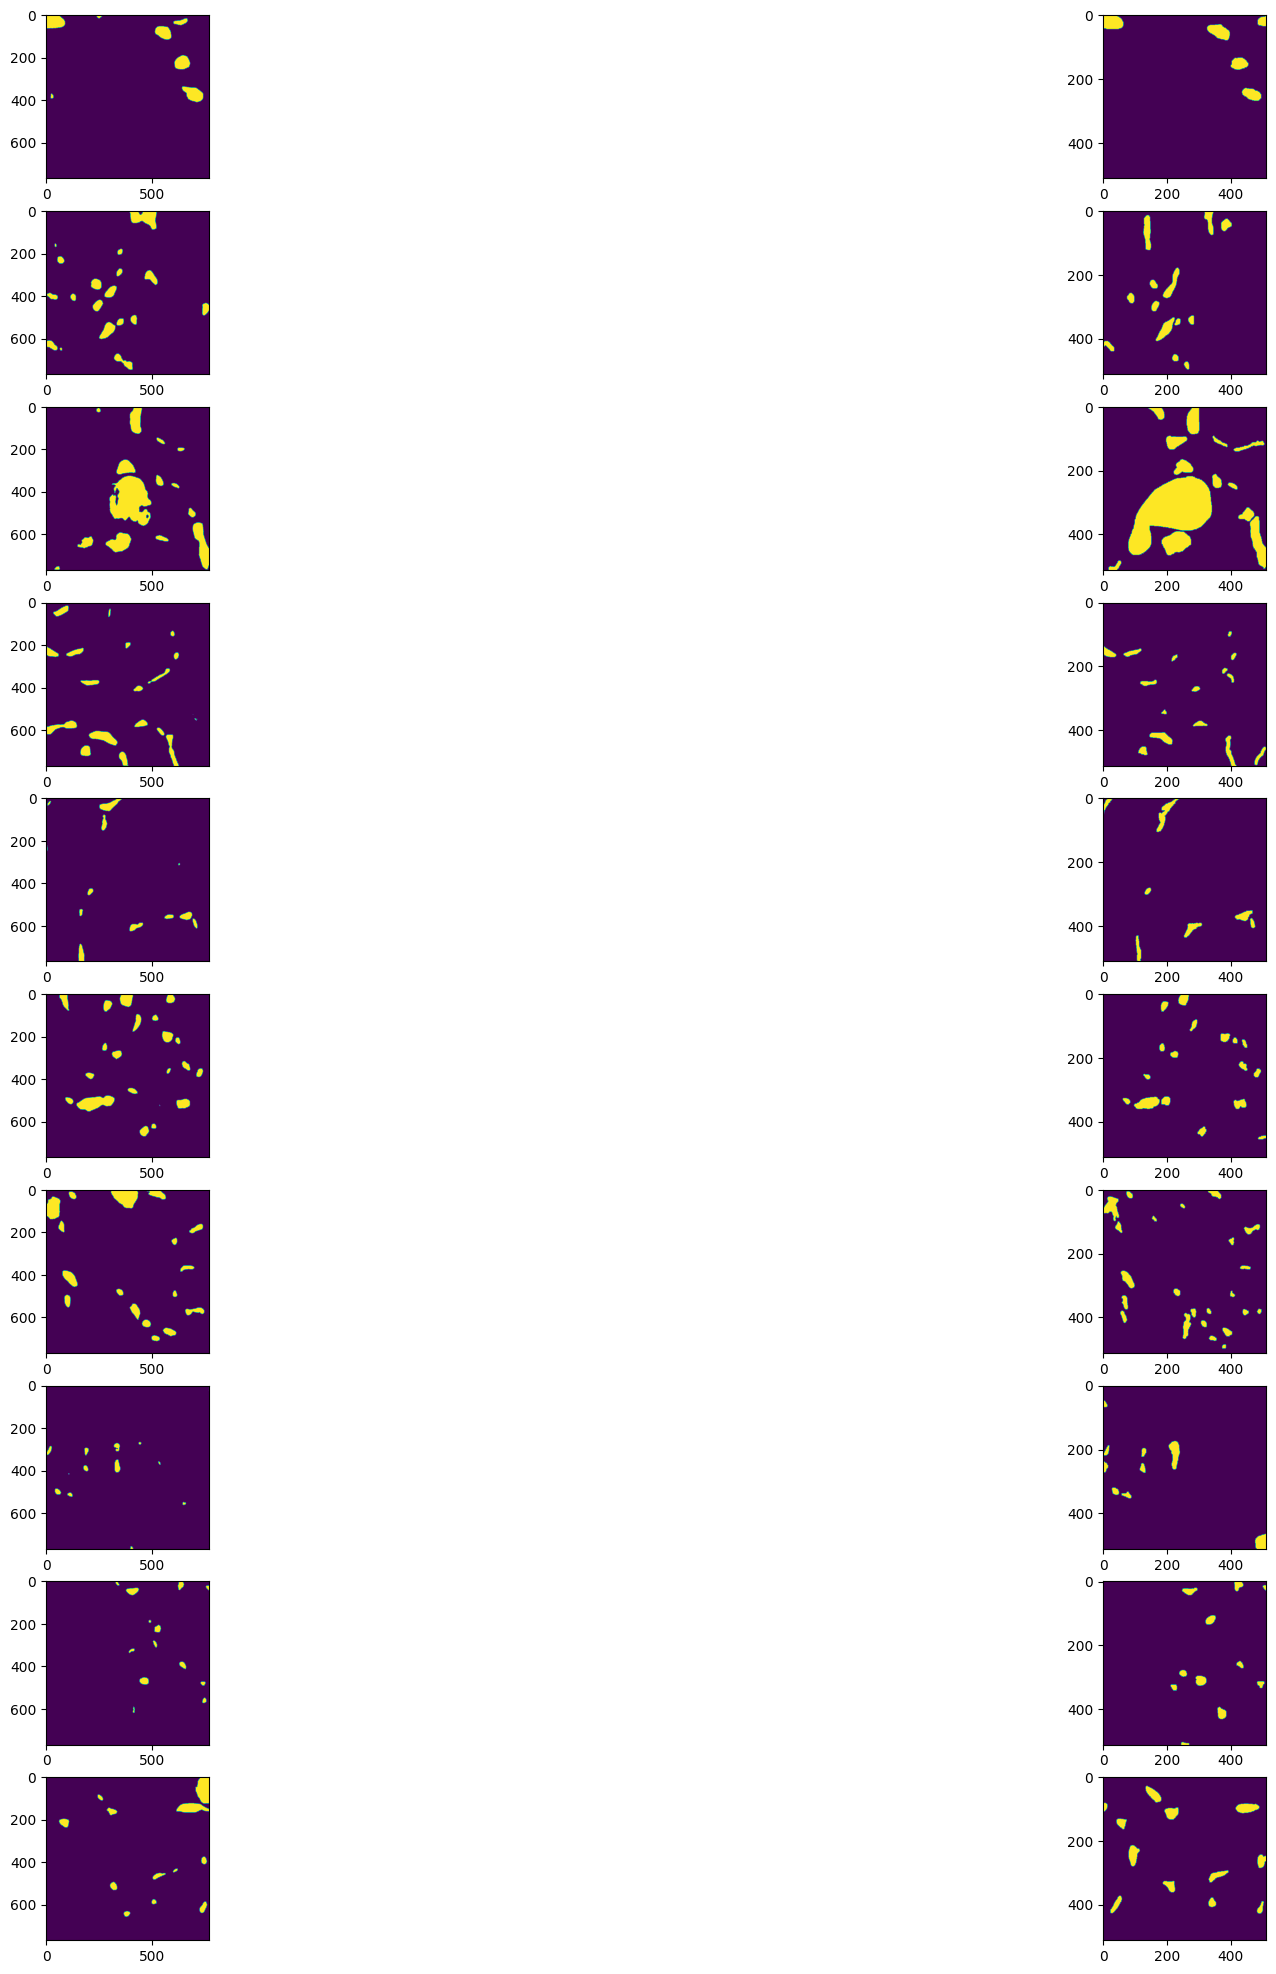

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(10, 2,figsize=(25,25))
with torch.no_grad():
    for  idx,(images,gtmask) in enumerate(tqdm(test_loader)):
        outputs = model.forward(images.to(device))
        outputs[outputs>0.50] = 1
        outputs[outputs<0.50] = 0
        mask = outputs.cpu().detach().reshape(768,768,1)
        ax[idx][0].imshow(mask)
        ax[idx][1].imshow(gtmask.reshape(512,512,1))
        if idx == 9:
            break

In [71]:
from timm.scheduler import CosineLRScheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineLRScheduler(optimizer, t_initial=50, lr_min=1e-7, 
                                  warmup_t=5, warmup_lr_init=5e-6, warmup_prefix=True)

In [72]:
lr = []
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
for epoch in range(50):
    scheduler.step(epoch)
    lr.append(get_lr(optimizer))

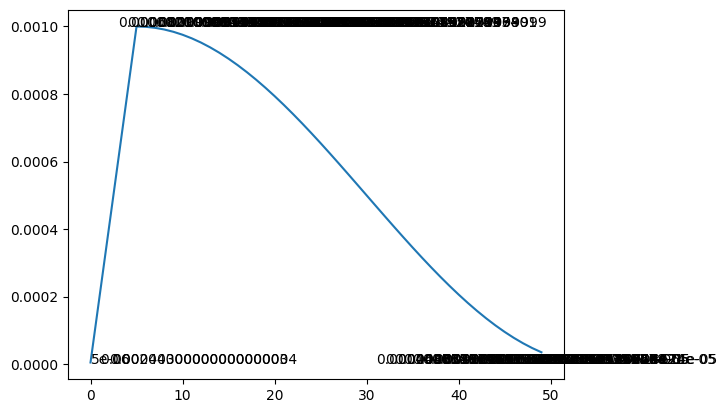

In [80]:
plt.plot(lr)
for i, value in enumerate(lr):
    plt.text(i, round(lr[i],3), value)
plt.show()